<img src="./detsd/hpe_logo.png" alt="HPE Logo" width="300">

# Textual Inversion (Stable Diffusion) with MLDE

Stable Diffusion is a deep learning, text-to-image model released in 2022. </br>It is primarily used to generate detailed images conditioned on text descriptions, though it can also be applied to other tasks such as inpainting, outpainting, and generating image-to-image translations guided by a text prompt. </br>It was developed by the start-up Stability AI in collaboration with a number of academic researchers and non-profit organizations.

For this exercise, we will leverage stable diffusion from Huggingface here: https://huggingface.co/runwayml/stable-diffusion-v1-5. </br>
Determined.AI is an ideal platform to finetune models from a modelhub like Huggingface. In this case, we already did the training of the model to teach it what a `det-logo-demo` means.

Here is our Determined AI logo:</br> </br>
<img src="./detsd/det_logo.png" alt="Determined Logo" width="150">

This notebook generates images from the trained textual inversion models generated with the `detsd.DetSDTextualInversionTrainer` class and saved as Determined checkpoints.AI.

## Step 1: Creating the Pipeline

Import the `DetSDTextualInversionPipeline` class from `detsd.py` (loaded via the `--context` flag above), which will be used to generate Stable Diffusion images.

In [1]:
import torch
from detsd import DetSDTextualInversionPipeline

Instantiate the pipeline with the default arguments:

In [2]:
detsd_pipeline = DetSDTextualInversionPipeline()

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

## Step 2: Load MLDE Checkpoints

We can now load textual-inversion checkpoints into the model. They are assumed to have been trained with `DetSDTextualInversionTrainer`, also contained in `detsd.py`.  These checkpoints can be specified by their uuid, assuming all such checkpoints exist on the master we are currently logged into.

Please go to the MLDE Cluster UI and find the project, experiment and the best checkpoint for a detsd finetune experiment. Fill in the `uuids` list below with the `uuid` `str` values of the best checkpoint you can find. (Replace `FIX ME` with checkpoint UUID)

In [3]:
uuids = ["16f9b509-19d8-4ffd-9e43-be86e92b770f"]
detsd_pipeline.load_from_uuids(uuids)

[PosixPath('checkpoints/16f9b509-19d8-4ffd-9e43-be86e92b770f')]

A sample embedding is also included in this environment (with corresponding concept token `det-logo-demo`) and can be loaded in as follows:

In [4]:
from os.path import exists
demo_concept_path = 'learned_embeddings_dict_demo.pt'
if exists(demo_concept_path):
    detsd_pipeline.load_from_checkpoint_dir(checkpoint_dir='.', learned_embeddings_filename='learned_embeddings_dict_demo.pt')

## Step 3: Generate Images

Finally, let's generate some art.

Grab the first concept which was loaded into the pipeline and store it as `first_concept`.  If no concepts were loaded above, fall back to using `brain logo, sharp lines, connected circles, concept art` as a default value for `first_concept`; vanilla Stable Diffusion is being used in this case.

In [5]:
all_added_concepts = detsd_pipeline.all_added_concepts
if all_added_concepts:
    first_concept = all_added_concepts[0]
else:
    first_concept = 'brain logo, sharp lines, connected circles, concept art'
print(f'Using "{first_concept}" as first_concept in the below\n')
print(f'All available concepts: {all_added_concepts}')

Using "det-logo" as first_concept in the below

All available concepts: ['det-logo', 'det-logo-demo']


Create a directory for saved images and an index for tracking the number of images created.

In [6]:
save_dir = 'generated_images'
! mkdir {save_dir}
num_generated_images = 0

mkdir: cannot create directory ‘generated_images’: File exists


### Step 3.1: Running the model with a custom text prompt

The below code uses creates `batch_size * num_images_per_prompt` total images from the prompt.

If you are generating using the demo embedding with `det-logo-demo` as `first_concept`, we recommend setting the guidance scale to a relatively low value, e.g. ~3.

In [7]:
#prompt = f'cyberpunk, neon light with {first_concept} metal, brain, incredible composition, masterpiece'
#prompt = f'cartoon, pastels with {first_concept}, brain, incredible composition, masterpiece'
#prompt = f'A highly detailed photograph of needle felted art of a {first_concept}'
#prompt = f'A surrealist oil painting by Salvador Dali of an orange brain using soft, blended colors'
prompt = f'A surrealist oil painting by Salvador Dali of a {first_concept} using soft, blended colors'

batch_size = 2
num_images_per_prompt = 2

generator = torch.Generator(device='cuda').manual_seed(2147483647)
output = detsd_pipeline(prompt=[prompt] * batch_size,
                        num_images_per_prompt=num_images_per_prompt,
                        num_inference_steps=50,
                        generator=generator,
                        guidance_scale=5.5
                       )

  0%|          | 0/51 [00:00<?, ?it/s]

Visualize and save:

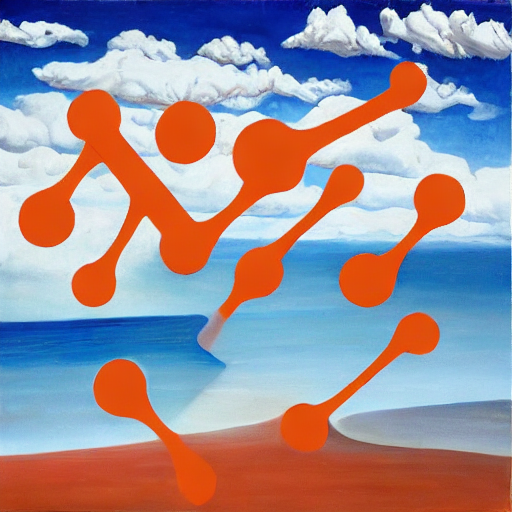

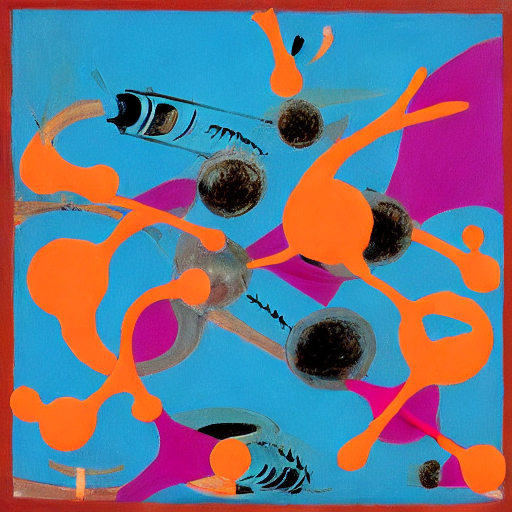

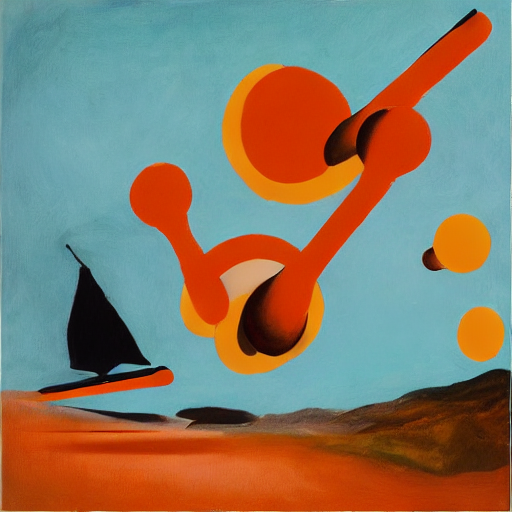

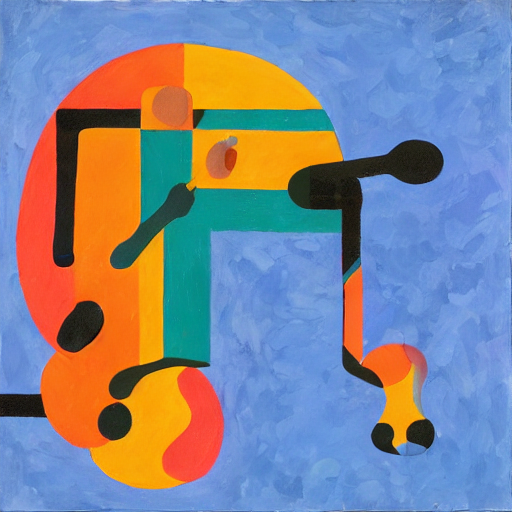

In [8]:
from pathlib import Path

for img, nsfw in zip(output.images, output.nsfw_content_detected):
    # Skip black images which are made when NSFW is detected.
    if not nsfw:
        num_generated_images += 1
        display(img)
        img.save(Path(save_dir).joinpath(f'{num_generated_images}.png'))

Explanation the some arguments above:
* `num_inference_steps`: how many steps to run the generation process for. ~50 is typical
* `guidance_scale`: tunes how much weight is given to the prompt during generation. 7.5 is the default, with larger numbers leading to stronger adherence to the prompt.
* `generator`: pass in a fixed `torch.Generator` instance for reproducible results.

`DetSDTextualInversionPipeline`'s `__call__` method accepts the same arguments as its underlying Huggingface `StableDiffusionPipeline` instance; see the [Hugging Face documentation](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion#diffusers.StableDiffusionPipeline.__call__) for information on all available arguments.